In [1]:
import os
import scipy
from tqdm import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
from pathlib import Path

from Model.Model import Modified_VGG19
from Functions.ImageOps import *

In [2]:
# Define device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
# Load Image Path
ImagePath = (Path(os.path.abspath('')) / 'Images' / 'pebbles.jpg').resolve()
ImagePath

WindowsPath('D:/ComputerScience/CV/Final Project/Project/Images/pebbles.jpg')

In [4]:
# Load Image
image_data = read_image(ImagePath).to(device)
white_data = create_white_noise_image(image_data).to(device)

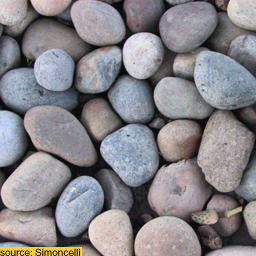

In [5]:
# Show Image
show_image(image_data, False)

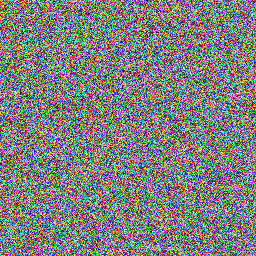

In [6]:
show_image(white_data, False)

In [7]:
# Load Model
model = Modified_VGG19(device=device)

In [8]:
# The first run model
model(image_data)
# Get feature maps
feature_maps = [ item.detach() for item in model.get_feature_maps() ]
# Clear grad data
model.zero_grad()

In [9]:
# Def feature maps -> gram matrices function
def feature_to_gram(feature_maps : list[torch.Tensor]) -> list[torch.Tensor]:
    feature_maps_flattened = [ torch.flatten(feature, start_dim=1) for feature in feature_maps ] 
    Gram_Matrices = [ torch.matmul(item, torch.transpose(item, 0, 1)) for item in feature_maps_flattened ]
    return Gram_Matrices

In [10]:
# Def Loss Function
def loss(feature_maps       : list[torch.Tensor], 
         train_feature_maps : list[torch.Tensor],
         weights            : torch.Tensor
        ) -> torch.Tensor:
    
    # Define each gram matrix loss
    def each_loss(gram_matrix : torch.Tensor, train_gram_matrix : torch.Tensor, shape : tuple[int]) -> torch.Tensor:
        assert train_gram_matrix.requires_grad == True
        assert gram_matrix.requires_grad       == False
        assert gram_matrix.shape == train_gram_matrix.shape
        tmp = gram_matrix - train_gram_matrix
        res = torch.pow(torch.linalg.matrix_norm(tmp), 2) / (4 * shape[0] * shape[0] * shape[1] * shape[1])
        return res
        
        
    shapes = [ item.shape for item in feature_maps ]
    
    gram_matrices       = feature_to_gram(feature_maps)
    train_gram_matrices = feature_to_gram(train_feature_maps)
    
    ret_value = torch.tensor([0.], requires_grad=False).to(device)
    
    assert len(gram_matrices) == len(train_gram_matrices)
    assert len(gram_matrices) == len(weights)
    
    for gram_matrix, train_gram_matrix, weight, shape in zip(gram_matrices, train_gram_matrices, weights, shapes):
        ret_value += weight * each_loss(gram_matrix=gram_matrix,
                                        train_gram_matrix=train_gram_matrix,
                                        shape=shape)
    return ret_value

In [11]:
# Define run
def train(model, feature_maps : list[torch.Tensor], image_data : torch.Tensor, optimizer, loops:int) -> torch.Tensor:
    weights = [ 0 for i in range(len(feature_maps)-14) ]
    weights = [1 for i in range(14)] + weights
    
    weights = torch.tensor(weights).to(device)
        
    for i in tqdm(range(loops)):
        def closure():
            optimizer.zero_grad()
            train_feature_maps = model(image_data)
            l = loss(feature_maps, train_feature_maps, weights=weights)
            l.backward()
            return l
        
        optimizer.step(closure)
        
    return image_data

In [12]:
import torch.optim as optim
data = white_data.detach()
data.requires_grad_(True)
optimizer = optim.LBFGS([data], lr=0.01, max_iter=20)

print(len(feature_maps))
train(model, feature_maps, data, optimizer, 700)

14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 700/700 [10:53<00:00,  1.07it/s]


tensor([[[ 0.8314,  0.5752,  0.5125,  ...,  0.1225, -0.0696,  0.0762],
         [ 0.2811,  0.6326,  0.5261,  ...,  0.1189,  0.0164,  0.2669],
         [ 0.7602,  0.6449,  0.7331,  ...,  0.0481,  0.1033,  0.0956],
         ...,
         [ 0.6116,  0.7400,  0.6644,  ...,  0.7702,  1.0046,  0.6824],
         [ 0.4837,  0.7211,  0.6614,  ...,  0.8900,  1.0122,  0.9056],
         [ 0.8002,  0.6304,  0.6013,  ...,  0.8663,  0.7701,  0.9140]],

        [[ 0.5754,  0.3370,  0.6667,  ..., -0.0059, -0.2506,  0.1619],
         [ 0.5964,  0.7788,  0.5543,  ...,  0.0440,  0.1888, -0.1629],
         [ 0.6889,  0.4728,  0.5767,  ...,  0.0588,  0.0018,  0.2838],
         ...,
         [ 0.7207,  0.5374,  0.6595,  ...,  0.8951,  0.7508,  0.9574],
         [ 0.8433,  0.6476,  0.7219,  ...,  0.9124,  0.6266,  0.9094],
         [ 0.5774,  0.5976,  0.6927,  ...,  0.7495,  1.0506,  0.6464]],

        [[ 0.3106,  0.7405,  0.4911,  ...,  0.2178,  0.0189, -0.0345],
         [ 0.8286,  0.4914,  0.7584,  ..., -0

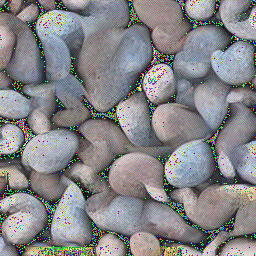

In [13]:
show_image(data, False)

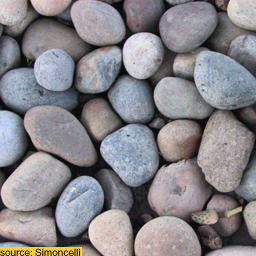

In [14]:
show_image(image_data, False)